In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction import text 

In [7]:
df = pd.read_csv('./project-3-master/data/roastme_toastme.csv')

In [8]:
df.head(3)

,subreddit,author,created_utc,body
0,RoastMe,Meditation-Blue-Ball,1601866157,Size 2 face on a size 6 head
1,RoastMe,Jayboosh_Returns,1601866153,His handwriting is sloppier than his hair
2,RoastMe,contraelmundo,1601866152,Chester Bennington minus Chester Bennington pl...


In [9]:
cvect = CountVectorizer(stop_words = 'english', max_features= 100)

In [10]:
dtm = cvect.fit_transform(df['body'])

In [11]:
dtm_df = pd.DataFrame(dtm.toarray(), columns = cvect.get_feature_names())

In [12]:
dtm_df.head(3)

,amazing,bad,beautiful,best,better,care,come,day,days,deserve,...,trying,ve,want,way,wish,won,work,world,year,years
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


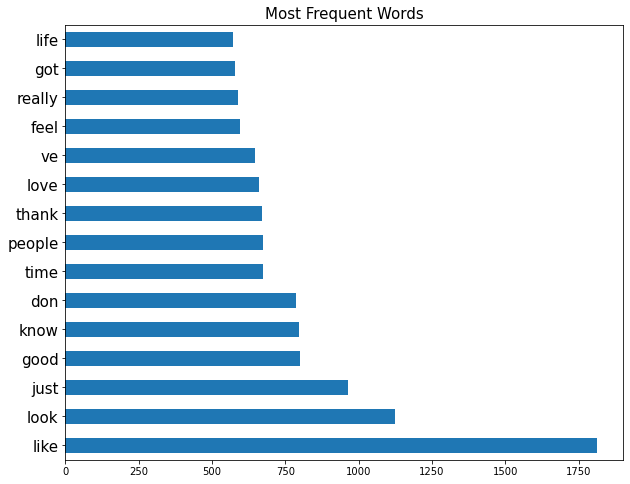

In [13]:
dtm_df.sum().nlargest(15).plot(kind = 'barh', figsize = (10,8))
plt.title('Most Frequent Words', fontsize = 15)
plt.yticks(fontsize = 15);

# MODELS <br>

In [14]:
X = df['body']
y = df['subreddit']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

<br>

In [16]:
#null model
y.value_counts(normalize=True)

RoastMe    0.5
toastme    0.5
Name: subreddit, dtype: float64

## Count Vectorizer & Logistic Regression model <br>

In [17]:
cvect = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']), max_features= 300)
ss = StandardScaler(with_mean=False)
logit = LogisticRegression(max_iter= 10_000)

In [18]:
pipe = make_pipeline(cvect, ss, logit)

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=300,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
  

In [20]:
pipe.score(X_test, y_test)

0.8332

In [21]:
pipe.score(X_train, y_train)

0.8541333333333333

In [22]:
word_coefs = pipe.named_steps['logisticregression'].coef_[0]
words = pipe.named_steps['countvectorizer'].get_feature_names()

In [23]:
word_coef_df = pd.DataFrame({'coefs': word_coefs, 'word': words})

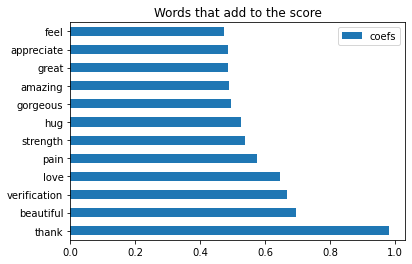

In [24]:
word_coef_df.nlargest(12, 'coefs').plot(kind = 'barh')
plt.yticks([i for i in range(12)], word_coef_df.nlargest(12, 'coefs')['word'])
plt.title('Words that add to the score');

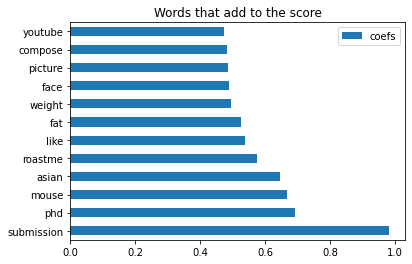

In [25]:
word_coef_df.nlargest(12, 'coefs').plot(kind = 'barh')
plt.yticks([i for i in range(12)], word_coef_df.nsmallest(12, 'coefs')['word'])
plt.title('Words that add to the score');

## Grid Search - Count Vectorizer & Logistic Regression (with Lemmatizer) <br> 

In [26]:
def split_lem(text):
    text = text.lower()
    lem = WordNetLemmatizer()
    return ' '.join([lem.lematize(word) for word in text.split()])

In [27]:
cvect = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']))
ss = StandardScaler(with_mean=False)
logit = LogisticRegression(max_iter= 10_000)

In [28]:
pipe = make_pipeline(cvect, ss, logit)

params = {
         'countvectorizer__max_features': [100, 200, 300],
         'countvectorizer__min_df': [1, 2, 6],
         'countvectorizer__max_df': [0.01, 0.5],
         'countvectorizer__ngram_range': [(1, 2), (1, 3)],
         'countvectorizer__preprocessor': [None, split_lem]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

In [29]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                                    

In [30]:
grid.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 300,
 'countvectorizer__min_df': 2,
 'countvectorizer__ngram_range': (1, 2),
 'countvectorizer__preprocessor': None}

In [31]:
grid.score(X_test, y_test)

0.8296

In [32]:
grid.score(X_train, y_train)

0.8548



## TF-IDF Vectorizer & Logistic Regression model <br>

In [33]:
tvect = TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']), max_features= 400)
ss = StandardScaler(with_mean=False)
logit = LogisticRegression(max_iter= 10_000)

In [34]:
pipe = make_pipeline(tvect, ss, logit)

In [35]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=400,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
  

In [36]:
pipe.score(X_test, y_test)

0.8252

In [37]:
pipe.score(X_train, y_train)

0.8596

In [38]:
word_coefs = pipe.named_steps['logisticregression'].coef_[0]
words = pipe.named_steps['tfidfvectorizer'].get_feature_names()

In [39]:
word_coef_df = pd.DataFrame({'coefs': word_coefs, 'word': words})

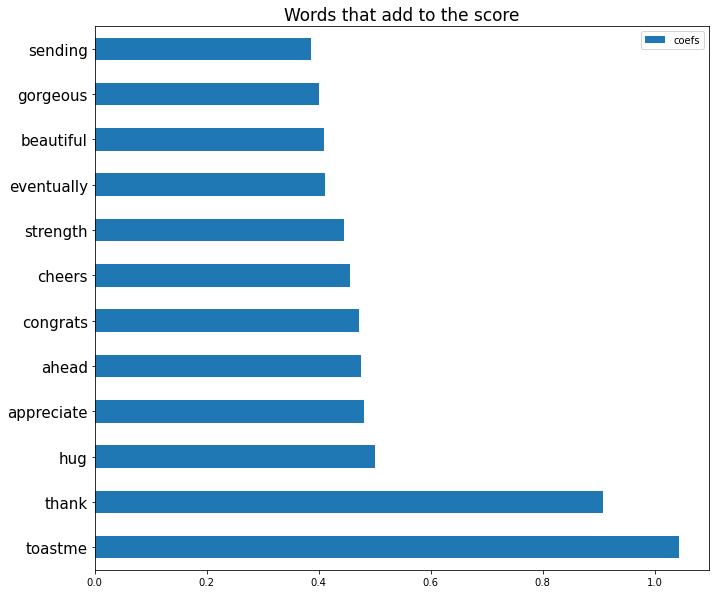

In [40]:
word_coef_df.nlargest(12, 'coefs').plot(kind = 'barh', figsize = (11,10))
plt.yticks([i for i in range(12)], word_coef_df.nlargest(12, 'coefs')['word'], fontsize = 15)
plt.title('Words that add to the score', fontsize = 17);

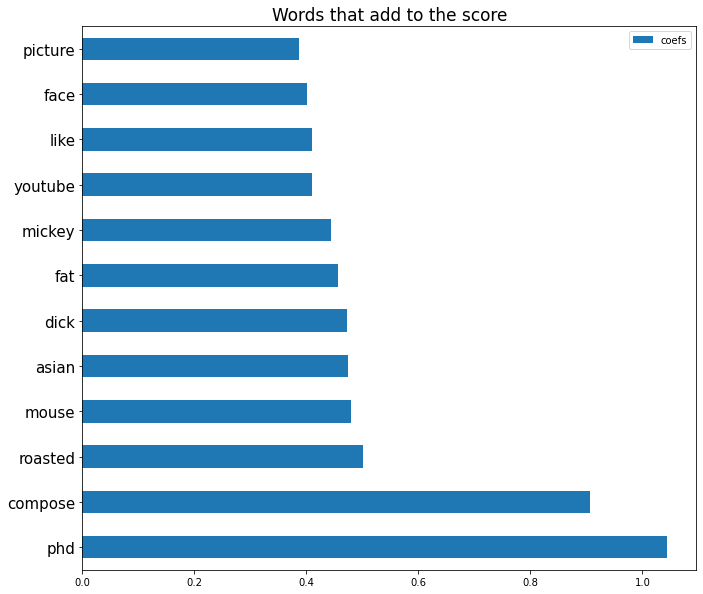

In [41]:
word_coef_df.nlargest(12, 'coefs').plot(kind = 'barh', figsize = (11,10))
plt.yticks([i for i in range(12)], word_coef_df.nsmallest(12, 'coefs')['word'], fontsize = 15)
plt.title('Words that add to the score', fontsize = 17);

In [51]:
pipe.predict(['you look beautiful'])

array(['toastme'], dtype=object)

In [50]:
pipe.predict(['you look hideous'])

array(['RoastMe'], dtype=object)

In [35]:
preds = pipe.predict(X_test)

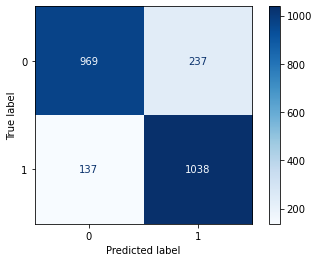

In [36]:
plot_confusion_matrix(pipe, X_test, y_test, cmap='Blues', values_format='d');

In [117]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [118]:
specificity = tn/(tn + fp)
specificity

0.8167495854063018

## Grid Search - TF-IDF Vectorizer & Logistic Regression (with Lemmatizer) <br>

In [119]:
tvect = TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']))
pipe = make_pipeline(tvect, ss, logit)

params = {
         'tfidfvectorizer__max_features': [300, 400, 500],
         'tfidfvectorizer__min_df': [1, 2, 6],
         'tfidfvectorizer__max_df': [0.1, 0.5],
         'tfidfvectorizer__ngram_range': [(1, 2), (1, 3)],
         'tfidfvectorizer__preprocessor': [None, split_lem]
}

grid = GridSearchCV(pipe, params, n_jobs=-1)

In [120]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'almost',
                                                                    

In [121]:
grid.best_params_

{'tfidfvectorizer__max_df': 0.5,
 'tfidfvectorizer__max_features': 400,
 'tfidfvectorizer__min_df': 2,
 'tfidfvectorizer__ngram_range': (1, 3),
 'tfidfvectorizer__preprocessor': None}

In [122]:
grid.score(X_test, y_test)

0.8429231415371693

In [123]:
grid.score(X_train, y_train)

0.8686826263474731

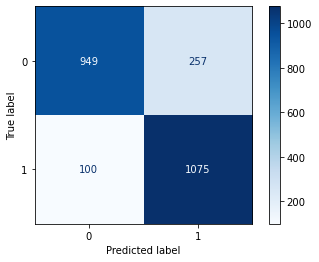

In [46]:
plot_confusion_matrix(grid, X_test, y_test, cmap='Blues', values_format='d');

In [ ]:
preds = pipe.predict(X_test)

In [125]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [126]:
specificity = tn/(tn + fp)
specificity

0.8167495854063018

###  Naive Bayes

In [55]:
cvect = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']), max_features= 500)
nbayes = MultinomialNB()

In [56]:
pipe = make_pipeline(cvect, nbayes)

In [57]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
  

In [58]:
pipe.score(X_test, y_test)

0.758504829903402

In [59]:
pipe.score(X_train, y_train)

0.761584768304634

###  Grid Search with Naive Bayes 

In [ ]:
cvect = CountVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']))
nbayes = MultinomialNB()

In [64]:
pipe = make_pipeline(cvect, nbayes)
params = {'countvectorizer__max_features': [200, 300, 400],
         'countvectorizer__min_df': [1, 2, 6, 10],
         'countvectorizer__max_df': [0.5, 0.8, .9],
         'countvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'countvectorizer__preprocessor': [None, split_lem]}

In [65]:
grid = GridSearchCV(pipe, params, n_jobs=-1)

In [66]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(max_features=500,
                                                        stop_words=frozenset({'a',
                                                                              'about',
                                                                              'above',
                                                                              'across',
                                                                              'after',
                                                                              'afterwards',
                                                                              'again',
                                                                              'against',
                                                                              'all',
                                                                              'alm

In [74]:
grid.best_params_

{'countvectorizer__max_df': 0.5,
 'countvectorizer__max_features': 200,
 'countvectorizer__min_df': 10,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None}

In [75]:
grid.score(X_test, y_test)

0.6842542584129622

In [76]:
grid.score(X_train, y_train)

0.6876731301939059

### Naive Bayes with TfidfVectorizer

In [72]:
tvect = TfidfVectorizer(stop_words = text.ENGLISH_STOP_WORDS.union(['roast']), max_features= 300)
nbayes = MultinomialNB()

In [73]:
pipe = make_pipeline(cvect, nbayes)

In [74]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_features=500,
                                 stop_words=frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                       'always', 'am', 'among',
                                                       'amongst', 'amoungst',
                                                       'amount', 'an', 'and',
                                                       'another', 'any',
                                                       'anyhow', 'anyone',
  

In [75]:
pipe.score(X_test, y_test)

0.758504829903402

In [76]:
pipe.score(X_train, y_train)

0.761584768304634

###  Grid Search with TF-IDFVectorizer & Naive Bayes 

In [77]:
tvect = TfidfVectorizer(stop_words = 'english')
pipe = make_pipeline(tvect, nbayes)
params = {
         'tfidfvectorizer__max_features': [50, 100, 150, 200],
         'tfidfvectorizer__min_df': [1, 2, 6, 10],
         'tfidfvectorizer__max_df': [0.5, 0.8, .9],
         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
         'tfidfvectorizer__preprocessor': [None, split_lem]}

In [78]:
grid = GridSearchCV(pipe, params, n_jobs=-1)

In [79]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(stop_words='english')),
                                       ('multinomialnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tfidfvectorizer__max_df': [0.5, 0.8, 0.9],
                         'tfidfvectorizer__max_features': [50, 100, 150, 200],
                         'tfidfvectorizer__min_df': [1, 2, 6, 10],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)],
                         'tfidfvectorizer__preprocessor': [None,
                                                           <function split_lem at 0x7fb4be1e2790>]})

In [80]:
grid.best_params_

{'tfidfvectorizer__max_df': 0.5,
 'tfidfvectorizer__max_features': 200,
 'tfidfvectorizer__min_df': 6,
 'tfidfvectorizer__ngram_range': (1, 2),
 'tfidfvectorizer__preprocessor': None}

In [85]:
grid.score(X_test, y_test)

0.7110457790844184

In [86]:
grid.score(X_train, y_train)

0.7050258994820103